In [1]:
import os
while not os.path.isfile('config.yaml'):
    os.chdir("../")
import pandas as pd
import yaml

with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

from api.api import Api
api = Api.create_api(config)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from helpers.helpers import filtered_symbols

In [2]:
def create_features(series, window_size):
    X = pd.DataFrame()
    for i in range(window_size):
        X[f't-{window_size-i}'] = series.shift(window_size-i)
    X.dropna(inplace=True)
    y = series[window_size:]
    return X, y

window_size = 20 
forward = 100

symbols = filtered_symbols(api, config)
dataset_X = pd.DataFrame()
dataset_y = pd.Series()

for symbol in symbols:
    data = api.klines(symbol, limit=900)
    data.Close = (data.Close - data.Close.mean()) / data.Close.std()
    prices = data
    data = data.Close[:-forward]
    X, y = create_features(data, window_size)
    dataset_X = pd.concat([dataset_X, X], ignore_index=True)
    dataset_y = pd.concat([dataset_y, y], ignore_index=True)




/Users/martin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/var/folders/m4/cdmqs17n5zq9nwvddw28zxgr0000gn/T/ipykernel_61851/2387988271.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  future_features[0, -1] = future_pred  # Update the last value with the predicted one
/Users/martin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/var/folders/m4/cdmqs17n5zq9nwvddw28zxgr0000gn/T/ipykernel_61851/2387988271.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you e

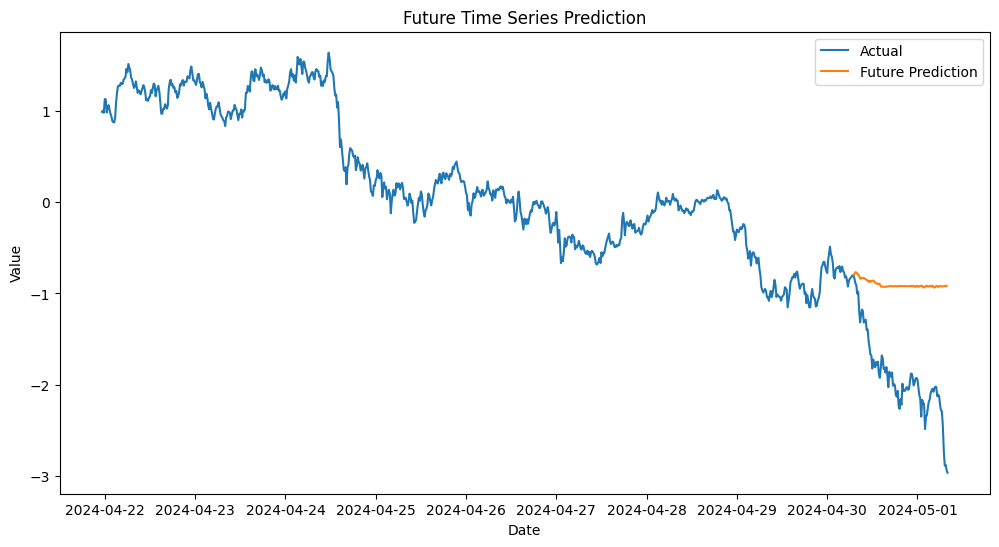

In [5]:

# Retrain the chosen model on the entire dataset
model = RandomForestRegressor() 
model.fit(dataset_X, dataset_y)
# Create features for future prediction
future_window = window_size  # Number of past observations to use for predicting the future
future_features = data[-window_size:].values.reshape(1, -1)  # Using the last window_size values as features

# Predict future values
future_predictions = []
for _ in range(forward):  # Predict 100 future values
    future_pred = model.predict(future_features)
    future_predictions.append(future_pred)
    future_features = np.roll(future_features, -1)  # Shift the window forward
    future_features[0, -1] = future_pred  # Update the last value with the predicted one

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(prices.index, prices.Close, label='Actual')
plt.plot(pd.date_range(start=data.index[-1], periods=forward, freq='15min'), future_predictions, label='Future Prediction')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Future Time Series Prediction')
plt.show()